In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import keyedvectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Connect to database

In [2]:
#Load database
conn = sqlite3.connect('amazon_food_reviews.sqlite')

original_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""", conn)

original_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data preprocessing

In [3]:
# Replace number rating with positive and negative strings
print(f'Size after droping duplicates {original_data.size}')
original_data = original_data.drop_duplicates({"UserId", "ProfileName", "Time", "Text"})

original_data["Score"] = original_data["Score"].map(lambda x: "positive" if x > 3 else "negative")
print(f'Size before droping duplicates {original_data.size}')

Size after droping duplicates 3641730
Size before droping duplicates 3641730


In [4]:
original_data = original_data[original_data.HelpfulnessDenominator >= original_data.HelpfulnessNumerator]
print(f'Size after droping Helpfulness denominator greater than Numerator {original_data.size}')

Size after droping Helpfulness denominator greater than Numerator 3641710


In [5]:
#Number of positive and negative reviews
original_data["Score"].value_counts()


positive    307061
negative     57110
Name: Score, dtype: int64

#### We are concerned only about the Reviews and the score column so extract those in to a new variable

In [42]:
filtered_data = original_data.loc[:,["Score","Text"]]

np_random_perm = np.random.permutation(2000)

filtered_data = filtered_data[filtered_data.Score == "positive"].iloc[np_random_perm, :]. \
                    append(filtered_data[filtered_data.Score == "negative"].iloc[np_random_perm, :])

print(filtered_data.shape)
print(filtered_data.isnull().any())
print(filtered_data.head())
print(filtered_data.tail())

(4000, 2)
Score    False
Text     False
dtype: bool
         Score                                               Text
360   positive  This is a great ham soup base.  I have used it...
99    positive  I'm presently on a diet and I was at my Fresh ...
407   positive  For me, Kettle is the best brand on the market...
1415  positive  Good product and decent shipping. However, the...
1497  positive  These are really good tasting chips, they aren...
          Score                                               Text
11833  negative  I love peanuts and I also love salt but these ...
4753   negative  My kids love these, and we've ordered them oft...
11328  negative  I've sampled several varieties of Eden Organic...
7864   negative  I am only drinking it, so it won't be wasted, ...
5064   negative  This food is phenomenal but WAY overpriced. I ...


## Text preprocessing : Remove Html Tags, Punctuations, alphanumerics and stop words. 

1. Obtain stem words for the remaining words and run algorithm using the data
2. Obtain lemma for each word and run algorithm using the data

In [43]:
# Code copied from the description python note book

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

#### Clean the reviews

In [44]:
processed_reviews=[]

for (index, review) in enumerate(filtered_data["Text"].values):
    processedReviewWords = []
    cleanedReview = cleanpunc(cleanhtml(review))
    for word in cleanedReview.split():
        word_in_lowercase = word.lower()
        if(word_in_lowercase.isalpha and \
           (word_in_lowercase not in stop) and \
           len(word_in_lowercase)>2):
            processedReviewWords.append(sno.stem(word_in_lowercase).encode('utf8'))
    processed_reviews.append(b" ".join(processedReviewWords))
    
print(processed_reviews[:5])

[b'great ham soup base use ham bean season greenbean great flavor', b'present diet fresh easi neighborhood groceri look possibl diet food want thing tasti non-fat low calori came home dozen item that discov tillen farm pickl crispi asparagus well ive alway like asparagus anyway ive enjoy sever brand pickl asparagus tillen farm brand realli realli good best recal there excel flavor big clove garlic bottom jar look forward eat cant believ good asparagus tast right front say calori per jar idea good diet food gari peterson', b'kettl best brand market realli know turn humbl potato someth fit god didnt think anyth could top salt pepper chip new favorit flavor pure real great everyth high addict hope come low fat version; low fat chip excel need flavor', b'good product decent ship howev price $15 later found item local store goug', b'realli good tast chip arent unhealthi eat fair amount love flavor']


#### Append the cleaned text to the table with the normal text

In [45]:
filtered_data["CleanedText"] = processed_reviews
filtered_data["CleanedText"] = filtered_data["CleanedText"].str.decode("utf-8")
filtered_data.head()

,Score,Text,CleanedText
360,positive,This is a great ham soup base. I have used it...,great ham soup base use ham bean season greenb...
99,positive,I'm presently on a diet and I was at my Fresh ...,present diet fresh easi neighborhood groceri l...
407,positive,"For me, Kettle is the best brand on the market...",kettl best brand market realli know turn humbl...
1415,positive,"Good product and decent shipping. However, the...",good product decent ship howev price $15 later...
1497,positive,"These are really good tasting chips, they aren...",realli good tast chip arent unhealthi eat fair...


#### Generate TFIDF of the cleaned text

In [51]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tfidf_vectorizer.fit_transform(filtered_data["CleanedText"].values)
print(type(final_tfidfinal_tfidff))
print(f"Shape of final_bigrams : {final_tfidf.get_shape()}")

<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (4000, 113894)


#### Train word2vector with the clean words we have

In [56]:
from gensim.models import Word2Vec

list_of_sentences_split_as_list_of_words = []
for review in filtered_data["CleanedText"].values:
    list_of_sentences_split_as_list_of_words.append(review.split())

w2v_model = Word2Vec(list_of_sentences_split_as_list_of_words, min_count=5, size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))
print(w2v_words[0:25])

2898
['great', 'soup', 'base', 'use', 'bean', 'season', 'flavor', 'present', 'diet', 'fresh', 'easi', 'neighborhood', 'groceri', 'look', 'possibl', 'food', 'want', 'thing', 'tasti', 'non-fat', 'low', 'calori', 'came', 'home', 'dozen']


#### Generate TF-IDF word2Vec (Code copied from the python book in description)

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vectorizer.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list

for (row,sent) in enumerate(list_of_sentences_split_as_list_of_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if (word in w2v_words) and (word in tfidf_feat):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)

In [77]:
print(f"length of tfIdf vector {len(tfidf_sent_vectors)}")
print(f"size of each vector {len(tfidf_sent_vectors[0])}")

length of tfIdf vector 4000
size of each vector 50


In [73]:
conn = sqlite3.connect('amazon_food_reviews_TfidfW2V.sqlite')
conn.text_factory = str
filtered_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, \
                     index_label=None, chunksize=None, dtype=None)

#### TSNE using tf-idf

<class 'numpy.ndarray'>
(4000, 2)


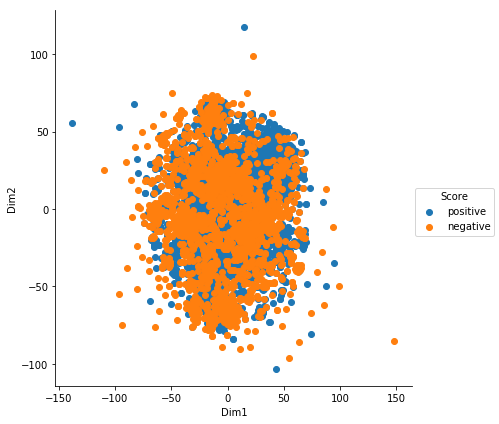

In [98]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = tsne_model.fit_transform(final_tfidf.todense())

print(type(tsne_data))
print(tsne_data.shape)

tsne_data_plot = np.vstack((tsne_data.T, filtered_data["Score"])).T

plot_df = pd.DataFrame(data=tsne_data_plot, columns=("Dim1", "Dim2","Score"))


sns.FacetGrid(plot_df, hue="Score", size=6) \
  .map(plt.scatter, 'Dim1', 'Dim2') \
  .add_legend()

plt.show()

#### T-SNE using TF-IDF, word2vector

<class 'numpy.ndarray'>
(4000, 2)


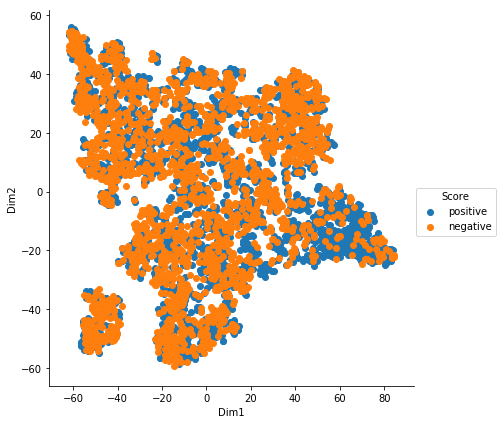

In [102]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = tsne_model.fit_transform(tfidf_sent_vectors)

print(type(tsne_data))
print(tsne_data.shape)

tsne_data_plot = np.vstack((tsne_data.T, filtered_data["Score"])).T

plot_df = pd.DataFrame(data=tsne_data_plot, columns=("Dim1", "Dim2","Score"))


sns.FacetGrid(plot_df, hue="Score", size=6) \
  .map(plt.scatter, 'Dim1', 'Dim2') \
  .add_legend()

plt.show()

## Conclusion

1. The T-SNE is offering no inference with regards to clustering.
2. The positive and negative food reviews are overlapping extensively.
3. There is no iota of clustering based on the sentiment of the reiview.